In [26]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

from tqdm import tqdm
tqdm.pandas()
from utils import *

### Setup custom heatmap colors

In [27]:
tab10 = sns.color_palette("tab10")
set1 = sns.color_palette("Set1")
colors = ["#000099", set1[1], tab10[9], set1[2], "#99cc00", "#ffcc00", set1[4], "#ff0000", "#cc0000", "#990000", "#660000", "#000000"]
positions = [0.0, 0.03, 0.05, 0.07, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.45, 1.0]
custom_cmap = mcolors.LinearSegmentedColormap.from_list('custom_colormap', list(zip(positions, colors)))

### Set paths and lookup table

In [28]:
# load new data to add geodata to
new_data_path ='../results/data_preprocessed/'
save_data_path = '../results/further_results/gifs/'
load_file_name = '2022-2023_bikethefts_preprocessed.csv'

GET_MONTH = {1: ['01', 'January'],
             2: ['02', 'February'],
             3: ['03', 'March'],
             4: ['04', 'April'],
             5: ['05', 'May'],
             6: ['06', 'June'],
             7: ['07', 'July'],
             8: ['08', 'August'],
             9: ['09', 'September'],
             10: ['10', 'October'],
             11: ['11', 'November'],
             12: ['12', 'December']}

### Create and save heatmaps for each month

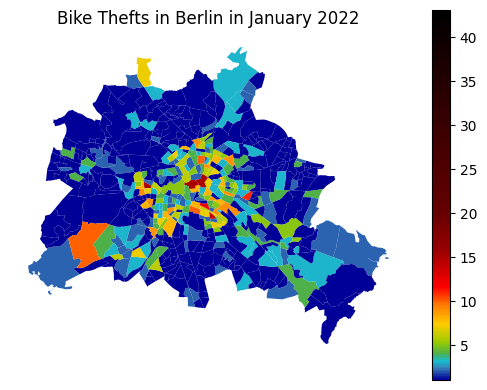

In [32]:
df = open_new_data(new_data_path=new_data_path+load_file_name, PLR_ID_column_name='LOR', encoding='ISO-8859-1')

df_ts = extract_timestamps(df.copy(), 'theft_start', 'mixed')

# filter by year and groupby PLR_ID and month
df_thefts_per_year = df_ts.groupby(['PLR_ID', 'theft_start_year', 'theft_start_month']).size().reset_index(name='thefts').sort_values(['theft_start_year', 'theft_start_month'])

vmin, vmax = df_thefts_per_year['thefts'].min(), df_thefts_per_year['thefts'].max()

# iterate over years and months to create a heatmap of bike thefts for each month
for year in set(df_thefts_per_year['theft_start_year']):

    df_thefts_per_month = df_thefts_per_year[df_thefts_per_year['theft_start_year'] == year]

    for month in set(df_thefts_per_month['theft_start_month']):

        save_file_name = f'{year}-{GET_MONTH[month][0]}_bikethefts_map.png'

        df_thefts = df_thefts_per_month[df_thefts_per_month['theft_start_month'] == month]

        # load geojson containing geodata
        geojson_path = '../../multipolygons/lor_planungsraeume_2021.geojson'
        geojson_data = gpd.read_file(geojson_path)

        # add geodata
        explore_df = get_geodata(df_thefts, geojson_data)

        # fill NaNs with 0
        explore_df['thefts'] = explore_df['thefts'].fillna(0)
        explore_df['theft_start_year'] = explore_df['theft_start_year'].fillna(year)
        explore_df['theft_start_month'] = explore_df['theft_start_month'].fillna(month)

        # Transfrom to GeoDataFrame
        explore_df = gpd.GeoDataFrame(explore_df)

        fig, ax = plt.subplots()
        explore_df.plot(column='thefts', ax=ax, legend=True, cmap=custom_cmap, vmax=vmax, vmin=vmin, edgecolor='None')
        ax.set_title(f'Bike Thefts in Berlin in {GET_MONTH[month][1]} {year}')
        ax.set_axis_off()
        
        # Save the figure
        # plt.savefig(save_data_path+save_file_name, bbox_inches='tight')

        if year==2022 and month==1: plt.show()
        
        # Close the current figure to free up memory
        plt.close(fig)